In [120]:
import pandas as pd
import numpy as np
from random import sample
from numpy.random import uniform

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from kmodes.kprototypes import KPrototypes

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import warnings
warnings.filterwarnings("ignore")

In [3]:
orders = pd.read_csv('orders.csv', lineterminator='\n')
users = pd.read_csv('users.csv')
users = users.iloc[:, 1:]

In [5]:
users.head()

user_id               name                          email    password  Age  \
0        1    Claire Ferguson        fordanthony@example.net  NKz0fWDh!5   20   
1        2     Jennifer Young              ann96@example.com  +i5Q91jt!s   24   
2        3  Jermaine Roberson            uwalker@example.org  eO4GqGusF(   22   
3        4   Rachel Carpenter  kimberlypatterson@example.net  d^c7O6odaS   22   
4        5       Shawn Parker    daniellebennett@example.com  8J#E5RMl1o   22   

   Gender Marital Status Occupation  Monthly Income  \
0  Female         Single    Student       No Income   
1  Female         Single    Student  Below Rs.10000   
2    Male         Single    Student  Below Rs.10000   
3  Female         Single    Student       No Income   
4    Male         Single    Student  Below Rs.10000   

  Educational Qualifications  Family size  
0              Post Graduate            4  
1                   Graduate            3  
2              Post Graduate            3  
3                   Graduate            6  
4              Post Graduate            4

<h1>EDA</h1>

In [6]:
print(f"Total Number of Users in database: {len(users.user_id.unique())}")
print(f"Total Number of Unique Users who ordered: {len(orders.user_id.unique())}")

Total Number of Users in database: 100000
Total Number of Unique Users who ordered: 77929


In [7]:
orders.currency.value_counts()

INR\r    150000
INR         279
USD           2
Name: currency, dtype: int64

In [8]:
orders.order_date = pd.to_datetime(orders.order_date)
orders['year_month'] = orders['order_date'].apply(lambda x: x.strftime('%Y-%m'))
temp = orders.groupby('year_month')['user_id'].nunique().reset_index()

In [9]:
fig = go.Figure(
    go.Bar(
        x=temp['year_month'],
        y=temp['user_id']
    )
)

# set title and axis labels
fig.update_layout(
    title='No. of orders by month',
    xaxis_title='Year-Month',
    yaxis_title='No. of orders'
)

# display chart
fig.show()

In [10]:
orders.describe()

sales_qty   sales_amount        user_id           r_id
count  150281.000000  150281.000000  150281.000000  148664.000000
mean       16.264997    1131.479343   49969.366553  363433.090513
std       114.761496    1492.091327   28902.241989  167889.871825
min         1.000000       0.000000       1.000000     211.000000
25%         1.000000     162.000000   24826.000000  233136.750000
50%         1.000000     444.000000   49951.000000  412597.500000
75%         7.000000    1528.000000   75084.000000  502200.500000
max     14049.000000    7241.000000   99999.000000  581031.000000

In [11]:
def process_orders(df):
    df = df.loc[df.sales_amount > 0]
    df = df.loc[df.currency.str.contains("INR")]
    df.sales_amount = round(df.sales_amount, 2)
    df['year_of_purchase'] = df.order_date.dt.year
    return df

orders_p = process_orders(orders)

<h1>RFM Analysis</h1>

In [12]:
def calculate_rfm(df):
    temp = df.copy()
    temp['ref_date'] = pd.to_datetime(temp.order_date.dt.date.max())
    temp['days_since'] = (temp.ref_date - temp.order_date).dt.days
    
    rfm_df = temp.groupby('user_id').aggregate({'order_date': lambda x: x.count(), 'sales_amount': lambda x: x.sum(), 'days_since': lambda x: x.min()}).reset_index()
    rfm_df = rfm_df.rename(columns = {'order_date': 'frequency', 'sales_amount': 'monetary_value', 'days_since': 'recency'})    
    return rfm_df

def get_missing_uids(df):
    all_values = set(range(1, 100000))
    my_set = set(df.user_id.unique())
    missing_user_id = all_values - my_set
    return missing_user_id

rfm_df = calculate_rfm(orders_p)

In [13]:
rfm_df.head()

user_id  frequency  monetary_value  recency
0        1          2         1672.00      590
1        2          3         4061.00      693
2        3          1         1206.53      408
3        4          1          102.00      506
4        5          2         2758.51      702

In [16]:
rfm_df.describe()

user_id     frequency  monetary_value       recency
count  77584.000000  77584.000000    77584.000000  77584.000000
mean   50018.302137      1.916246     2191.677370    415.898948
std    28892.738658      1.035292     2382.270062    272.101773
min        1.000000      1.000000        0.250000      0.000000
25%    24963.750000      1.000000      398.000000    179.000000
50%    49993.500000      2.000000     1310.000000    381.000000
75%    75119.250000      2.000000     3225.252500    631.000000
max    99999.000000      8.000000    21890.000000    996.000000

On average, customers spend $2191.67, have a recency of 420 days and order at least 1.9 times

In [17]:
quantiles = rfm_df.quantile(q = [0.25, 0.50, 0.75])
quantiles

user_id  frequency  monetary_value  recency
0.25  24963.75        1.0        398.0000    179.0
0.50  49993.50        2.0       1310.0000    381.0
0.75  75119.25        2.0       3225.2525    631.0

In [18]:
def rec_score(x):
    if x < 179.0:
        return 4
    elif 179.0 <= x < 381.0:
        return 3
    elif 381.0 <= x < 631.0:
        return 2
    else:
        return 1

def freq_score(x):
    if x > 3.0:
        return 4
    elif 3.0 >= x > 2.0:
        return 3
    elif 2.0 >= x > 1.0:
        return 2
    else:
        return 1

def mon_score(x):
    if x > 3225.2525:
        return 4
    elif 3225.2525 >= x > 1310.0000:
        return 3
    elif 1310.0000 >= x > 398.0000:
        return 2
    else: 
        return 1

In [19]:
rfm_df['recency_score'] = rfm_df['recency'].apply(rec_score)
rfm_df['frequency_score'] = rfm_df['frequency'].apply(freq_score)
rfm_df['monetary_score'] = rfm_df['monetary_value'].apply(mon_score)
rfm_df.sample(5)

user_id  frequency  monetary_value  recency  recency_score  \
45598    58746          2         3584.00      652              1   
9902     12795          2         1903.00      256              3   
76231    98309          2         4642.80      380              3   
58551    75593          2         2521.79      241              3   
4345      5621          2         4787.00      247              3   

       frequency_score  monetary_score  
45598                2               4  
9902                 2               3  
76231                2               4  
58551                2               3  
4345                 2               4

In [20]:
fig = px.pie(rfm_df, values = rfm_df['frequency_score'].value_counts(), 
             names = (rfm_df["frequency_score"].value_counts()).index, 
             title = 'Frequency_Score Distribution')
fig.show()

In [21]:
fig = px.pie(rfm_df, values = rfm_df['frequency_score'].value_counts(), 
             names = (rfm_df["frequency_score"].value_counts()).index, 
             title = 'Frequency_Score Distribution')
fig.show()

In [22]:
fig = px.pie(rfm_df, values = rfm_df['monetary_score'].value_counts(), 
             names = (rfm_df["monetary_score"].value_counts()).index, 
             title = 'Monetary_Score Distribution')
fig.show()

In [23]:
rfm_df['rfm_score'] = (rfm_df['recency_score'].astype(str) + rfm_df['frequency_score'].astype(str) + 
                            rfm_df['monetary_score'].astype(str))
rfm_df.sample(5)

user_id  frequency  monetary_value  recency  recency_score  \
22855    29439          3         1274.18      301              3   
6174      7982          1          287.00      302              3   
21649    27887          2          509.00      273              3   
17731    22834          1         4100.19      249              3   
33083    42626          3         4680.00      126              4   

       frequency_score  monetary_score rfm_score  
22855                3               2       332  
6174                 1               1       311  
21649                2               2       322  
17731                1               4       314  
33083                3               4       434

In [24]:
rfm_df.rfm_score.value_counts()

111    6734
211    4142
112    3425
311    2620
113    2480
       ... 
143      42
142      23
131      14
341       7
441       7
Name: rfm_score, Length: 62, dtype: int64

In [25]:
fig = px.histogram(rfm_df, x = rfm_df['rfm_score'].value_counts().index, 
                   y = rfm_df['rfm_score'].value_counts().values, 
                   title = 'Customer_RFM Distribution',
                   labels = dict(x = "rfm_score", y ="counts"))
fig.show()

In [26]:
rfm_df['rfm_level'] = rfm_df['recency_score'] + rfm_df['frequency_score'] + rfm_df['monetary_score']
rfm_df.sample(5)

user_id  frequency  monetary_value  recency  recency_score  \
21732    27986          2         1040.26      130              4   
28746    36992          2          287.00      371              3   
38090    49087          1         1370.00      308              3   
22367    28806          2         7467.00      574              2   
41756    53824          2          245.00      337              3   

       frequency_score  monetary_score rfm_score  rfm_level  
21732                2               2       422          8  
28746                2               1       321          6  
38090                1               3       313          7  
22367                2               4       224          8  
41756                2               1       321          6

In [27]:
rfm_df.rfm_level.value_counts()

6     11401
7     10369
8     10066
5      9642
9      8529
4      8223
3      6734
10     6452
11     4071
12     2097
Name: rfm_level, dtype: int64

In [28]:
fig = px.pie(rfm_df, values = rfm_df['rfm_level'].value_counts(), 
             names = (rfm_df["rfm_level"].value_counts()).index, 
             title = 'RFM_level Distribution')
fig.show()

In [29]:
def segments(df):
    if df['rfm_level'] == 12 :
        return 'champion'
    elif (df['rfm_level'] == 11) or (df['rfm_level'] == 10 ):
        return 'loyal_customer'
    elif (df['rfm_level'] == 9) or (df['rfm_level'] == 8 ):
        return 'promising'
    elif (df['rfm_level'] == 7) or (df['rfm_level'] == 6 ):
        return 'need_attention'
    elif (df['rfm_level'] == 5) or (df['rfm_level'] == 4 ):
        return 'hibernating'
    else:  
        return 'almost_lost'

In [30]:
rfm_df['customer_segment'] = rfm_df.apply(segments,axis=1)
rfm_df.sample(5)

user_id  frequency  monetary_value  recency  recency_score  \
23115    29772          1           144.0      610              2   
20540    26472          1           134.0      974              1   
1727      2199          3           360.0       59              4   
50353    64950          3          1783.0       36              4   
50802    65551          1            97.0      591              2   

       frequency_score  monetary_score rfm_score  rfm_level customer_segment  
23115                1               1       211          4      hibernating  
20540                1               1       111          3      almost_lost  
1727                 3               1       431          8        promising  
50353                3               3       433         10   loyal_customer  
50802                1               1       211          4      hibernating

In [43]:
rfm_df.head()

user_id  frequency  monetary_value  recency  recency_score  \
0        1          2         1672.00      590              2   
1        2          3         4061.00      693              1   
2        3          1         1206.53      408              2   
3        4          1          102.00      506              2   
4        5          2         2758.51      702              1   

   frequency_score  monetary_score rfm_score  rfm_level customer_segment  
0                2               3       223          7   need_attention  
1                3               4       134          8        promising  
2                1               2       212          5      hibernating  
3                1               1       211          4      hibernating  
4                2               3       123          6   need_attention

In [44]:
rfm_df.customer_segment.value_counts()

need_attention    21770
promising         18595
hibernating       17865
loyal_customer    10523
almost_lost        6734
champion           2097
Name: customer_segment, dtype: int64

In [63]:
fig = px.histogram(rfm_df, x = rfm_df['customer_segment'].value_counts().index, 
                   y = rfm_df['customer_segment'].value_counts().values, 
                   title = 'Customer_Segment Distribution',
                   labels = dict(x = "customer_segment", y ="counts"))

fig.update_layout(title_font=dict(size=30), 
                  font=dict(size=22),
                  width=1000,
                  height=800)

fig.show()

In [64]:
fig = px.pie(rfm_df, values = rfm_df['customer_segment'].value_counts(), 
             names = (rfm_df["customer_segment"].value_counts()).index, 
             title = 'Customer_Segment Distribution')

fig.update_layout(title_font=dict(size=30), 
                  font=dict(size=22),
                  width=1000,
                  height=800)

fig.show()

In [35]:
rfm_df.groupby('rfm_level').agg({'recency': ['mean','min','max','count'],
                                       'frequency': ['mean','min','max','count'],
                                       'monetary_value': ['mean','min','max','count'] }).round(1)

recency                  frequency                monetary_value  \
             mean  min  max  count      mean min max  count           mean   
rfm_level                                                                    
3           811.2  631  995   6734       1.0   1   1   6734          178.4   
4           653.1  381  996   8223       1.1   1   2   8223          421.6   
5           559.9  179  996   9642       1.3   1   3   9642          890.9   
6           447.3    0  995  11401       1.4   1   3  11401         1449.9   
7           371.9    1  980  10369       1.8   1   5  10369         1952.9   
8           299.3    0  960  10066       2.1   1   6  10066         2593.1   
9           241.1    3  921   8529       2.5   1   6   8529         3436.8   
10          193.7    2  630   6452       3.0   2   7   6452         4444.8   
11          143.6    0  380   4071       3.7   3   8   4071         5352.6   
12           84.2    0  178   2097       4.5   4   8   2097         6732.2   

                                   
              min      max  count  
rfm_level                          
3             2.3    398.0   6734  
4             6.4   1310.0   8223  
5             0.2   3223.8   9642  
6             2.1   7241.0  11401  
7            60.0  13814.0  10369  
8           161.0  15319.0  10066  
9           320.0  16736.9   8529  
10          421.0  21890.0   6452  
11         1310.0  19500.0   4071  
12         3226.0  21152.0   2097

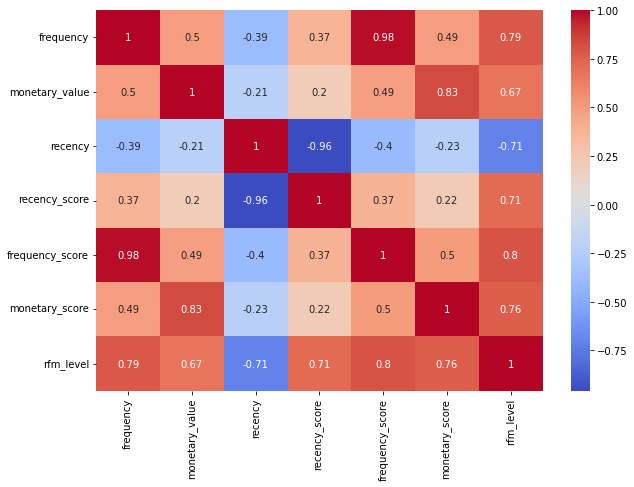

In [36]:
plt.figure(figsize=(10,7))
sns.heatmap(rfm_df.iloc[:, 1:].corr(),annot=True, cmap="coolwarm");

In [37]:
df_temp = rfm_df.iloc[:, 1:].corr()

count = "Done"
feature =[]
collinear=[]
for col in df_temp.columns:
    for i in df_temp.index:
        if (df_temp[col][i]> .9 and df_temp[col][i] < 1) or (df_temp[col][i]< -.9 and df_temp[col][i] > -1) :
                feature.append(col)
                collinear.append(i)
                print(f"mmulticolinearity alert in between {col} - {i}")
        else:
            print(f"For {col} and {i}, there is NO multicollinearity problem") 

print("The number of strong corelated features:", count) 

For frequency and frequency, there is NO multicollinearity problem
For frequency and monetary_value, there is NO multicollinearity problem
For frequency and recency, there is NO multicollinearity problem
For frequency and recency_score, there is NO multicollinearity problem
multicolinearity alert in between frequency - frequency_score
For frequency and monetary_score, there is NO multicollinearity problem
For frequency and rfm_level, there is NO multicollinearity problem
For monetary_value and frequency, there is NO multicollinearity problem
For monetary_value and monetary_value, there is NO multicollinearity problem
For monetary_value and recency, there is NO multicollinearity problem
For monetary_value and recency_score, there is NO multicollinearity problem
For monetary_value and frequency_score, there is NO multicollinearity problem
For monetary_value and monetary_score, there is NO multicollinearity problem
For monetary_value and rfm_level, there is NO multicollinearity problem
Fo

<Figure size 1440x1440 with 0 Axes>

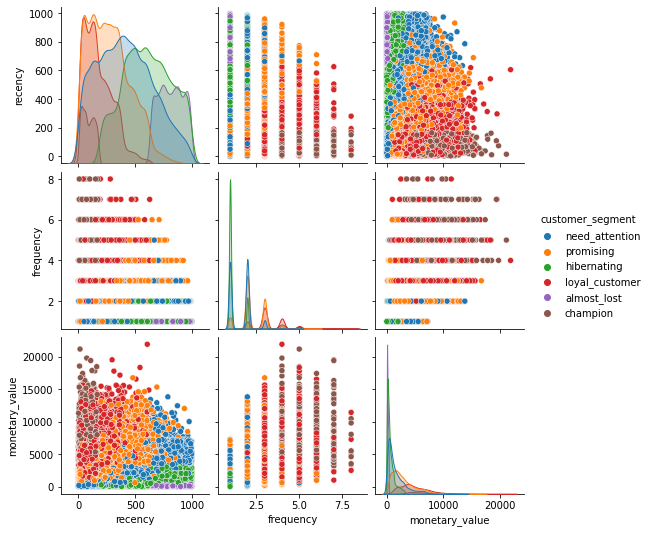

In [38]:
plt.figure(figsize = (20,20))
sns.pairplot(rfm_df[['recency', 'frequency', 'monetary_value','customer_segment']], hue = 'customer_segment');

<AxesSubplot:>

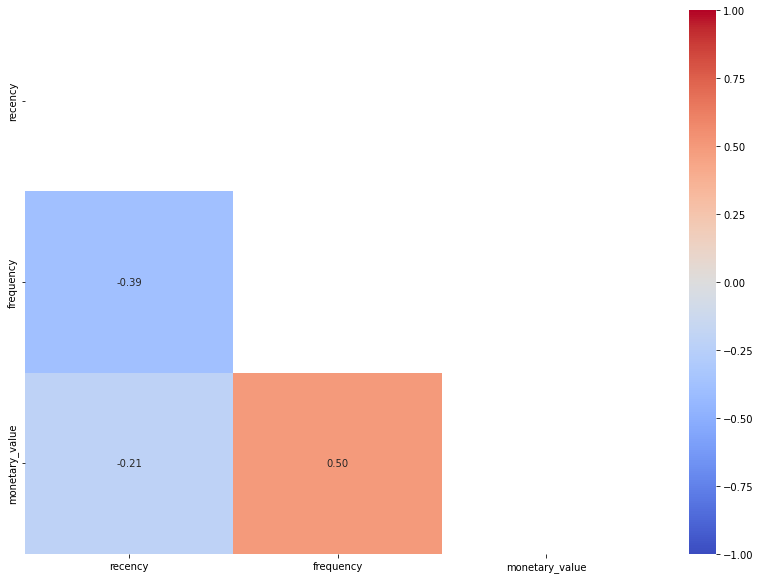

In [39]:
matrix = np.triu(rfm_df[['recency','frequency','monetary_value']].corr())
fig, ax = plt.subplots(figsize=(14,10)) 
sns.heatmap (rfm_df[['recency','frequency','monetary_value']].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax)

<h1>Merging Users with RFM Data</h1>

In [186]:
merged = rfm_df.merge(users, right_on='user_id', left_on='user_id').drop(columns=['email', 'password', 'name'])
merged.head()

user_id  frequency  monetary_value  recency  recency_score  frequency_score  monetary_score rfm_score  rfm_level customer_segment  Age  Gender Marital Status Occupation  Monthly Income Educational Qualifications  Family size
0        1          2         1672.00      590              2                2               3       223          7   need_attention   20  Female         Single    Student       No Income              Post Graduate            4
1        2          3         4061.00      693              1                3               4       134          8        promising   24  Female         Single    Student  Below Rs.10000                   Graduate            3
2        3          1         1206.53      408              2                1               2       212          5      hibernating   22    Male         Single    Student  Below Rs.10000              Post Graduate            3
3        4          1          102.00      506              2                1               1       211          4      hibernating   22  Female         Single    Student       No Income                   Graduate            6
4        5          2         2758.51      702              1                2               3       123          6   need_attention   22    Male         Single    Student  Below Rs.10000              Post Graduate            4

In [187]:
merged_f = merged[['user_id', 'recency', 'frequency', 'monetary_value', 'Age', 'Gender', 'Marital Status', 'Occupation', 'Monthly Income', 'Educational Qualifications', 'Family size']]
merged_f.head()

user_id  recency  frequency  monetary_value  Age  Gender Marital Status Occupation  Monthly Income Educational Qualifications  Family size
0        1      590          2         1672.00   20  Female         Single    Student       No Income              Post Graduate            4
1        2      693          3         4061.00   24  Female         Single    Student  Below Rs.10000                   Graduate            3
2        3      408          1         1206.53   22    Male         Single    Student  Below Rs.10000              Post Graduate            3
3        4      506          1          102.00   22  Female         Single    Student       No Income                   Graduate            6
4        5      702          2         2758.51   22    Male         Single    Student  Below Rs.10000              Post Graduate            4

<h1>Skew Check</h1>

In [188]:
skew_vals = merged_f.skew().sort_values(ascending=False)
skew_vals

monetary_value    1.665372
frequency         1.218349
Age               0.800376
Family size       0.398206
recency           0.336298
user_id           0.000442
dtype: float64

In [189]:
skew_limit = 0.8
skew_cols = skew_vals[abs(skew_vals) > skew_limit].sort_values(ascending=False)
skew_cols

monetary_value    1.665372
frequency         1.218349
Age               0.800376
dtype: float64

In [190]:
merged_f[skew_cols.index].iplot(kind='histogram',subplots=True,bins=50)

<h2>Log Transformation</h2>

In [191]:
rfm_log = merged_f.set_index('user_id')
rfm_log.frequency = rfm_log.frequency.apply(np.log1p, axis=1).round(3)
rfm_log.monetary_value = rfm_log.monetary_value.apply(np.log1p, axis=1).round(3)
rfm_log.Age = rfm_log.Age.apply(np.log1p, axis=1).round(3)
rfm_log.head()

recency  frequency  monetary_value    Age  Gender Marital Status Occupation  Monthly Income Educational Qualifications  Family size
user_id                                                                                                                                     
1            590      1.099           7.422  3.045  Female         Single    Student       No Income              Post Graduate            4
2            693      1.386           8.309  3.219  Female         Single    Student  Below Rs.10000                   Graduate            3
3            408      0.693           7.096  3.135    Male         Single    Student  Below Rs.10000              Post Graduate            3
4            506      0.693           4.635  3.135  Female         Single    Student       No Income                   Graduate            6
5            702      1.099           7.923  3.135    Male         Single    Student  Below Rs.10000              Post Graduate            4

In [192]:
rfm_log.skew()

recency           0.336298
frequency         0.557680
monetary_value   -0.420170
Age               0.528167
Family size       0.398206
dtype: float64

<h2>Power Transformation</h2>

In [193]:
rfm_trans = merged_f[['user_id', 'frequency', 'monetary_value', 'Age']].set_index('user_id')
pt_cols = rfm_trans.columns
non_pt_cols = list(set(merged_f.columns) - set(pt_cols))
non_pt_df = merged_f[non_pt_cols]

pt = PowerTransformer(method='yeo-johnson')
trans = pt.fit_transform(rfm_trans)

trans_df = pd.DataFrame(trans, columns=pt_cols)
rfm_trans = pd.concat([non_pt_df, trans_df], axis=1).set_index('user_id')
rfm_trans.head()

Gender  recency  Family size  Monthly Income Occupation Educational Qualifications Marital Status  frequency  monetary_value       Age
user_id                                                                                                                                        
1        Female      590            4       No Income    Student              Post Graduate         Single   0.427913        0.237960 -1.997246
2        Female      693            3  Below Rs.10000    Student                   Graduate         Single   1.162322        1.007230 -0.074006
3          Male      408            3  Below Rs.10000    Student              Post Graduate         Single  -1.063768       -0.019118 -0.921185
4        Female      506            6       No Income    Student                   Graduate         Single  -1.063768       -1.590640 -0.921185
5          Male      702            4  Below Rs.10000    Student              Post Graduate         Single   0.427913        0.658842 -0.921185

In [194]:
rfm_trans.skew()

recency           0.336298
Family size       0.398206
frequency         0.158365
monetary_value   -0.065318
Age               0.012192
dtype: float64

<h1>Standardization</h1>

In [195]:
# standardization
scaler = StandardScaler()

num_cols = rfm_trans._get_numeric_data().columns
cols = rfm_trans.columns
cat_cols = list(set(cols) - set(num_cols))

temp = rfm_trans[num_cols]
temp_scaled = pd.DataFrame(scaler.fit_transform(temp), columns=temp.columns, index=temp.index)

cat_df = rfm_trans[cat_cols]

rfm_trans_final = pd.concat([cat_df, temp_scaled], axis=1)
rfm_trans_final.head()

Gender  Monthly Income Occupation Educational Qualifications Marital Status   recency  Family size  frequency  monetary_value       Age
user_id                                                                                                                                         
1        Female       No Income    Student              Post Graduate         Single  0.639842     0.533521   0.427913        0.237960 -1.997246
2        Female  Below Rs.10000    Student                   Graduate         Single  1.018379    -0.207699   1.162322        1.007230 -0.074006
3          Male  Below Rs.10000    Student              Post Graduate         Single -0.029030    -0.207699  -1.063768       -0.019118 -0.921185
4        Female       No Income    Student                   Graduate         Single  0.331132     2.015960  -1.063768       -1.590640 -0.921185
5          Male  Below Rs.10000    Student              Post Graduate         Single  1.051455     0.533521   0.427913        0.658842 -0.921185

<h1>Hopkins Statistic</h1>

In [196]:
def hopkins_statistic(X):
    
    X=X.values  #convert dataframe to a numpy array
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures
    
    
    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))
    
    
    
    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]
   
    
    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X)
    
    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour
    
    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]
    
 
    
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    
    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H

In [197]:
l = [] #list to hold values for each call
for i in range(20):
    H=hopkins_statistic(rfm_trans_final[num_cols])
    l.append(H)

print(f'Average Hopkins Statistic: {np.mean(l)}')

Average Hopkins Statistic: 0.9002786900626688


<h1>K-Prototypes (RFM as Continuous Vars)</h1>

In [ ]:
# Specify the indices of the categorical variables
cat_cols = [0, 1, 2, 3, 4]

# Specify the number of clusters you want to form
n_clusters = 3

# Specify the random state for reproducibility
random_state = 42

kproto = KPrototypes(n_clusters=n_clusters, n_init=5, init='Cao', verbose=2, random_state=random_state, n_jobs=-2, max_iter=15)

# fit the model to the data
clusters = kproto.fit_predict(rfm_trans_final, categorical=cat_cols)

cost = []
ss = []

for num_clusters in range(2,10):
    kproto = KPrototypes(n_clusters=num_clusters, n_init=5, init='Cao', verbose=2, random_state=random_state, n_jobs=-2, max_iter=15)
    kproto.fit_predict(rfm_trans_final, categorical=cat_cols)
    cost.append(kproto.cost_)
    
    silhouette_avg = silhouette_score(rfm_trans_final[num_cols], kproto.labels_)
    ss.append(silhouette_avg)

<h2>Scree Plot (Elbow Method)</h2>

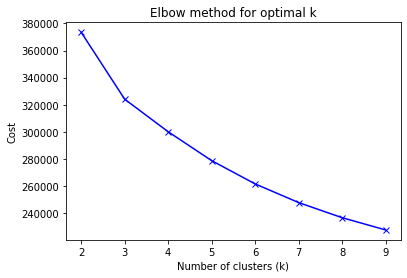

In [199]:
plt.plot(range(2,10), cost, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow method for optimal k')
plt.show()

<h2>Silhouette Method</h2>

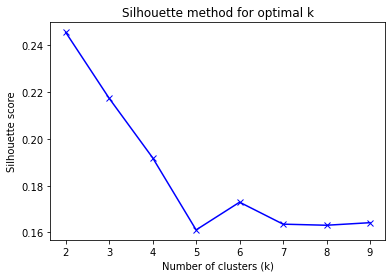

In [200]:
plt.plot(range(2,10), ss, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette method for optimal k')
plt.show()

<h2>3 Clusters</h2>

In [ ]:
# Specify the indices of the categorical variables
cat_cols = [0, 1, 2, 3, 4]

# Specify the number of clusters you want to form
n_clusters = 3

# Specify the random state for reproducibility
random_state = 42

kproto = KPrototypes(n_clusters=n_clusters, n_init=5, init='Cao', verbose=2, random_state=random_state, n_jobs=-2, max_iter=15)

# fit the model to the data
clusters = kproto.fit_predict(rfm_trans_final, categorical=cat_cols)

In [201]:
merged['clusters'] = clusters
merged.head(10)

user_id  frequency  monetary_value  recency  recency_score  frequency_score  monetary_score rfm_score  rfm_level customer_segment  Age  Gender Marital Status Occupation   Monthly Income Educational Qualifications  Family size  clusters
0        1          2         1672.00      590              2                2               3       223          7   need_attention   20  Female         Single    Student        No Income              Post Graduate            4         1
1        2          3         4061.00      693              1                3               4       134          8        promising   24  Female         Single    Student   Below Rs.10000                   Graduate            3         1
2        3          1         1206.53      408              2                1               2       212          5      hibernating   22    Male         Single    Student   Below Rs.10000              Post Graduate            3         0
3        4          1          102.00      506              2                1               1       211          4      hibernating   22  Female         Single    Student        No Income                   Graduate            6         0
4        5          2         2758.51      702              1                2               3       123          6   need_attention   22    Male         Single    Student   Below Rs.10000              Post Graduate            4         1
5        6          1           83.00      623              2                1               1       211          4      hibernating   27  Female        Married   Employee  More than 50000              Post Graduate            2         0
6        8          1          241.00      371              3                1               1       311          5      hibernating   24  Female         Single    Student        No Income              Post Graduate            3         0
7        9          3         7940.00      232              3                3               4       334         10   loyal_customer   23  Female         Single    Student        No Income              Post Graduate            2         1
8       10          2         2773.00       67              4                2               3       423          9        promising   23  Female         Single    Student        No Income              Post Graduate            4         1
9       13          3         3819.00      147              4                3               4       434         11   loyal_customer   23    Male         Single    Student        No Income              Post Graduate            5         1

In [ ]:
merged.to_csv('merged.csv')

In [202]:
merged.clusters.value_counts()

1    32077
0    29125
2    16382
Name: clusters, dtype: int64

<h2>Visualizing the Clusters</h2>

In [203]:
temp_cols = num_cols.to_list() + ['clusters']

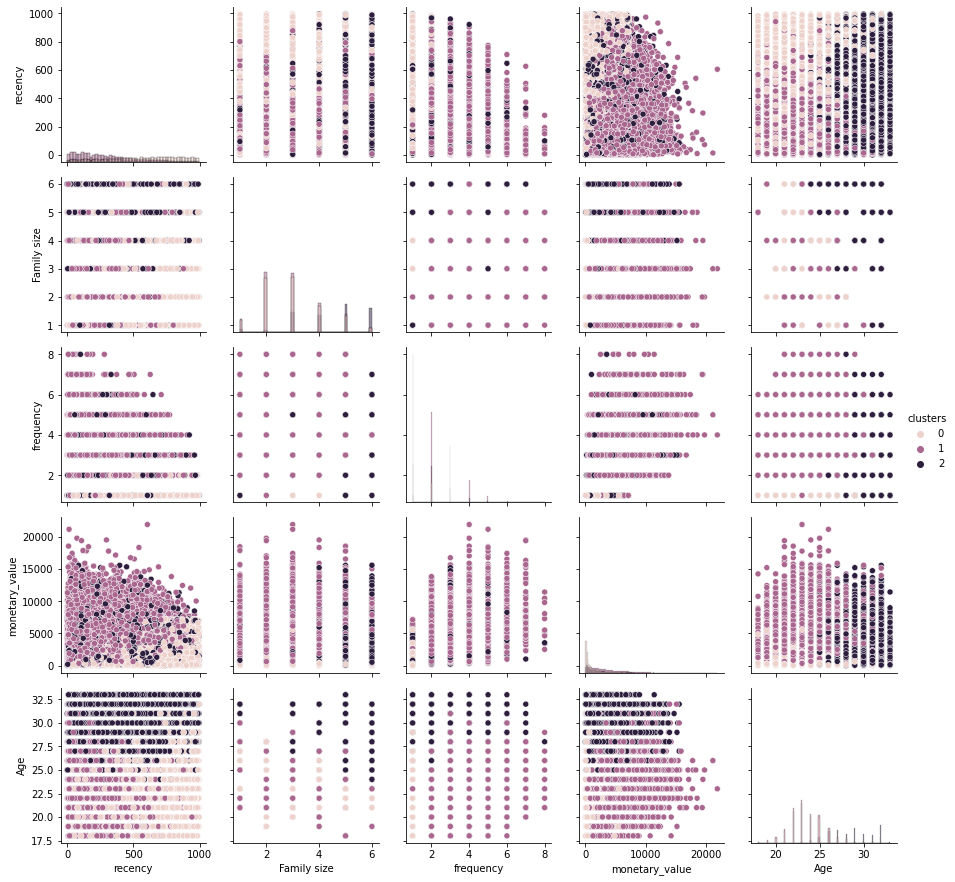

In [204]:
g = sns.PairGrid(merged[temp_cols], hue="clusters")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

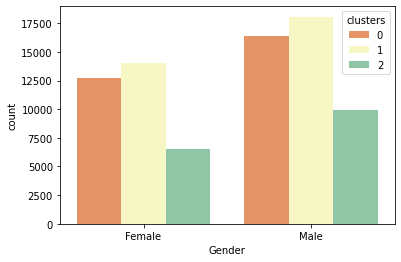

In [205]:
ax = sns.countplot(data=merged, x='Gender', hue='clusters', palette='Spectral')

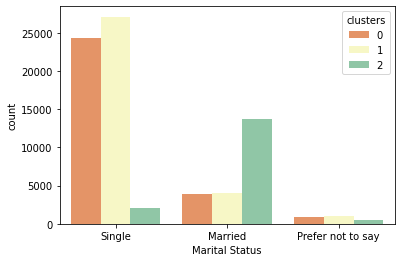

In [206]:
ax = sns.countplot(data=merged, x='Marital Status', hue='clusters', palette='Spectral')

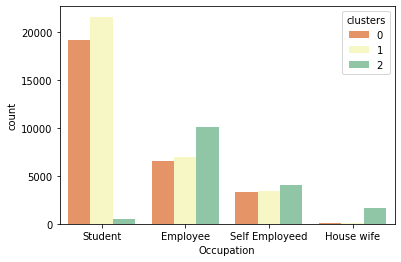

In [207]:
ax = sns.countplot(data=merged, x='Occupation', hue='clusters', palette='Spectral')

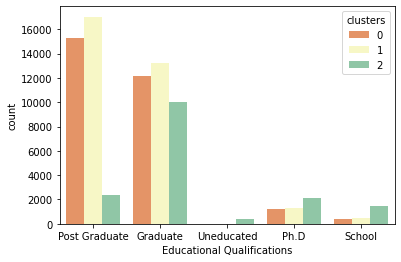

In [208]:
ax = sns.countplot(data=merged, x='Educational Qualifications', hue='clusters', palette='Spectral')

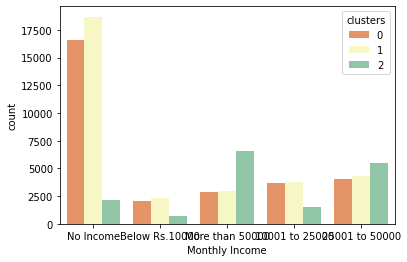

In [209]:
ax = sns.countplot(data=merged, x='Monthly Income', hue='clusters', palette='Spectral')

In [210]:
merged[merged.clusters == 0].describe()

user_id     frequency  monetary_value       recency  recency_score  frequency_score  monetary_score     rfm_level           Age   Family size  clusters
count  29125.000000  29125.000000    29125.000000  29125.000000   29125.000000     29125.000000     29125.00000  29125.000000  29125.000000  29125.000000   29125.0
mean   50266.404532      1.121236      887.777331    576.246936       1.876120         1.121236         1.76697      4.764326     23.607725      2.963605       0.0
std    28789.402724      0.330692     1196.771607    262.195512       0.997646         0.330692         0.91286      1.266375      2.055767      1.173773       0.0
min        3.000000      1.000000        0.250000      1.000000       1.000000         1.000000         1.00000      3.000000     18.000000      1.000000       0.0
25%    25684.000000      1.000000      167.000000    380.000000       1.000000         1.000000         1.00000      4.000000     22.000000      2.000000       0.0
50%    50408.000000      1.000000      397.850000    606.000000       2.000000         1.000000         1.00000      5.000000     23.000000      3.000000       0.0
75%    75168.000000      1.000000     1093.000000    794.000000       3.000000         1.000000         2.00000      6.000000     25.000000      4.000000       0.0
max    99986.000000      3.000000     7236.000000    996.000000       4.000000         3.000000         4.00000      8.000000     32.000000      6.000000       0.0

In [211]:
merged[merged.clusters == 1].describe()

user_id     frequency  monetary_value       recency  recency_score  frequency_score  monetary_score     rfm_level           Age   Family size  clusters
count  32077.000000  32077.000000    32077.000000  32077.000000   32077.000000     32077.000000    32077.000000  32077.000000  32077.000000  32077.000000   32077.0
mean   49845.068616      2.658353     3407.605193    276.290364       3.045765         2.597188        3.147614      8.790566     23.515229      2.960813       1.0
std    28976.098894      0.958467     2633.010285    200.020679       0.931479         0.808714        0.877559      1.600355      1.982746      1.172833       0.0
min        1.000000      1.000000       74.000000      0.000000       1.000000         1.000000        1.000000      5.000000     18.000000      1.000000       1.0
25%    24494.000000      2.000000     1343.000000    112.000000       2.000000         2.000000        3.000000      8.000000     22.000000      2.000000       1.0
50%    49713.000000      2.000000     2755.770000    240.000000       3.000000         2.000000        3.000000      9.000000     23.000000      3.000000       1.0
75%    75079.000000      3.000000     4858.180000    406.000000       4.000000         3.000000        4.000000     10.000000     25.000000      4.000000       1.0
max    99999.000000      8.000000    21890.000000    980.000000       4.000000         4.000000        4.000000     12.000000     32.000000      6.000000       1.0

In [212]:
merged[merged.clusters == 2].describe()

user_id     frequency  monetary_value       recency  recency_score  frequency_score  monetary_score     rfm_level           Age   Family size  clusters
count  16382.000000  16382.000000    16382.000000  16382.000000   16382.000000     16382.000000    16382.000000  16382.000000  16382.000000  16382.000000   16382.0
mean   49916.411610      1.876572     2128.972686    404.184227       2.527652         1.858625        2.530521      6.916799     28.633927      4.468502       2.0
std    28911.334699      0.937730     2198.907802    257.056597       1.083673         0.881910        1.076134      2.127486      2.493012      1.299045       0.0
min       38.000000      1.000000       14.590000      0.000000       1.000000         1.000000        1.000000      3.000000     23.000000      1.000000       2.0
25%    24779.000000      1.000000      468.000000    190.000000       2.000000         1.000000        2.000000      5.000000     27.000000      3.000000       2.0
50%    49894.500000      2.000000     1352.000000    374.000000       3.000000         2.000000        3.000000      7.000000     29.000000      5.000000       2.0
75%    75098.750000      2.000000     3110.965000    598.000000       3.000000         2.000000        3.000000      8.000000     31.000000      6.000000       2.0
max    99995.000000      8.000000    15562.980000    996.000000       4.000000         4.000000        4.000000     12.000000     33.000000      6.000000       2.0